# Sales Forecast and analysis

## Quod Financial Technical Test

> Done by **Tristan PERROT**


## Import libraries


In [15]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from xgboost import XGBRegressor

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Import Data

In [16]:
DATA_DIR = '..' + os.sep + 'data'

transactions_1 = pd.read_csv(DATA_DIR + os.sep + 'transactions_1.csv', index_col=0, parse_dates=['date'])
transactions_2 = pd.read_csv(DATA_DIR + os.sep + 'transactions_2.csv', index_col=0, parse_dates=['date'])

In [17]:
transactions_1

,customer_id,product_id,date
0,8649525,Opel,2017-01-31 09:31:08.873000+00:00
1,8649525,Volkswagen,2017-02-03 16:59:16.610000+00:00
2,8649525,Volkswagen,2017-02-05 19:47:55.353000+00:00
3,8649525,Volkswagen,2017-02-05 19:48:14.633000+00:00
4,8649525,Volkswagen,2017-02-06 09:59:49.053000+00:00
...,...,...,...
499995,8822663,Fiat,2019-12-17 10:15:10.907000+00:00
499996,8822663,Renault,2017-09-26 08:00:46.090000+00:00
499997,8822663,Renault,2017-09-26 08:17:36.350000+00:00
499998,8822663,Renault,2017-09-26 09:05:09.700000+00:00


In [18]:
transactions_2

,customer_id,product_id,date
500000,8822663,Abarth,2018-06-28 09:19:11.130000+00:00
500001,8822663,Peugeot,2019-07-17 08:06:29.500000+00:00
500002,8822663,Nissan,2017-06-22 07:29:22.440000+00:00
500003,8822663,Nissan,2017-06-22 07:50:10.863000+00:00
500004,8822663,Nissan,2017-06-22 08:40:35.923000+00:00
...,...,...,...
975950,1111821,Renault,2019-05-17 10:06:43.037000+00:00
975951,4232782,Renault,2017-10-27 17:49:54.483000+00:00
975952,4746355,Seat,2019-01-09 16:31:08.133000+00:00
975953,4743766,Opel,2017-03-29 16:25:05.907000+00:00


In [19]:
transactions_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   customer_id  500000 non-null  int64              
 1   product_id   500000 non-null  object             
 2   date         500000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 15.3+ MB


In [20]:
all_transactions = pd.concat([transactions_1, transactions_2])
all_transactions = all_transactions.drop_duplicates()
all_transactions['date'] = pd.to_datetime(all_transactions['date']).dt.tz_localize(None)
all_transactions['month'] = all_transactions['date'].dt.to_period('M')

In [21]:
unique_products = all_transactions['product_id'].unique()
unique_products

array(['Opel', 'Volkswagen', 'BMW', 'Abarth', 'Audi', 'Seat', 'Peugeot',
       'Mercedes Benz', 'Renault', 'Lancia', 'Fiat', 'Skoda', 'Toyota',
       'Citroen', 'Nissan', 'Ssangyong', 'Volvo', 'Jaguar', 'Ford',
       'Alfa Romeo', 'DS', 'Mini', 'Lexus', 'Mazda', 'Kia', 'Hyundai',
       'Jeep', 'Land Rover', 'Chevrolet', 'Infiniti', 'Honda', 'Dacia',
       'Tesla', 'Mitsubishi', 'Subaru', 'Iveco', 'Porsche', 'Suzuki',
       'Chrysler', 'Undefined', 'Piaggio', 'Yamaha', 'Isuzu',
       'Not a make', '├ÅTS', 'Harley-Davidson', 'Tata', 'MCC/Smart',
       'Equipe', 'Oxygen'], dtype=object)

## Data Analysis

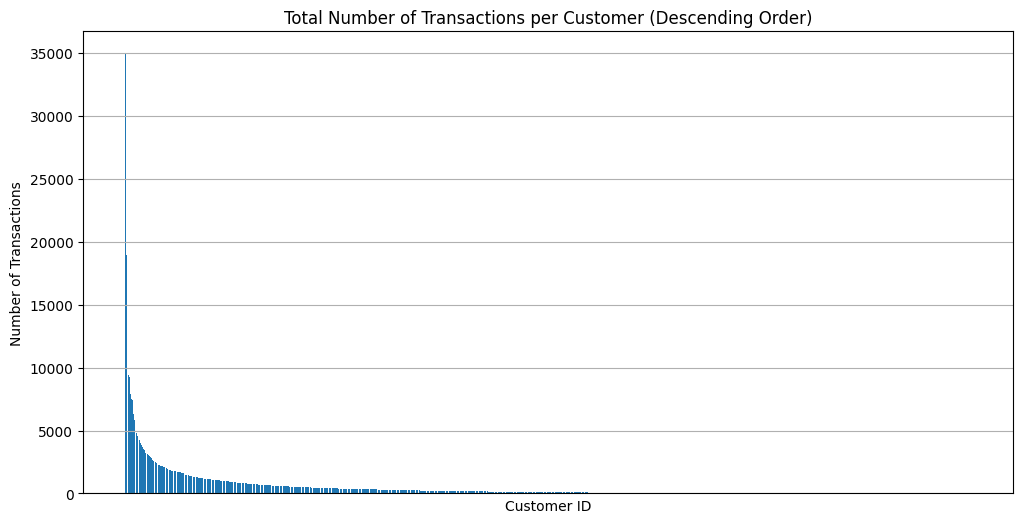

In [22]:
# Combine transactions and count the number per customer
transactions_per_customer = pd.concat([transactions_1, transactions_2]).groupby('customer_id').size()

# Sort in descending order
transactions_per_customer = transactions_per_customer.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(transactions_per_customer.index.astype(str), transactions_per_customer.values)

# Labels and title
plt.xlabel("Customer ID")  # Remove x-axis label text
plt.ylabel("Number of Transactions")
plt.title("Total Number of Transactions per Customer (Descending Order)")
plt.grid(axis='y')

# Remove x-axis ticks and labels for readability
plt.xticks([], []) 

# Show the plot
plt.show()

## Prediction model

### Preprocessing

In [23]:
df = all_transactions.copy()
df_grouped = df.groupby(['customer_id', 'month']).agg(
                transaction_count=('customer_id', 'count')  # Assuming each row is a transaction
            ).reset_index()

# Create lag features for time series modeling
def create_lags(df, lags=[1, 2, 3]):
    for lag in lags:
        df[f'transactions_lag_{lag}'] = df.groupby('customer_id')['transaction_count'].shift(lag)
    return df

df_grouped = create_lags(df_grouped)
df_grouped.dropna(inplace=True)

df_grouped['rolling_mean'] = df_grouped.groupby('customer_id')['transaction_count'].transform(lambda x: x.rolling(window=3).mean())
df_grouped['rolling_std'] = df_grouped.groupby('customer_id')['transaction_count'].transform(lambda x: x.rolling(window=3).std())

# Create seasonal features
df_grouped['month_num'] = df_grouped['month'].dt.month
df_grouped['quarter'] = df_grouped['month'].dt.quarter
df_grouped['year'] = df_grouped['month'].dt.year

# One-hot encode the month and quarter
df_grouped = pd.get_dummies(df_grouped, columns=['month_num', 'quarter'], drop_first=True)


### Data Split and Scaling

In [24]:
# Split training and test set
separation_date = '2019-02'
separation_date = pd.to_datetime(separation_date).to_period('M')
train = df_grouped[df_grouped['month'] < separation_date]
end_prediction_date = separation_date + 3
test = df_grouped[(df_grouped['month'] >= separation_date) & (df_grouped['month'] < end_prediction_date)]


X_train = train.drop(columns=['customer_id', 'month', 'transaction_count'])
y_train = train['transaction_count']
X_test = test.drop(columns=['customer_id', 'month', 'transaction_count'])
y_test = test['transaction_count']

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Special preparation for LSTM

In [25]:
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    X_filled = pd.DataFrame(X).fillna(0)
    y_filled = pd.DataFrame(y).fillna(0)
    for i in range(len(X_filled) - time_steps):
        Xs.append(X_filled[i:(i + time_steps)])
        ys.append(y_filled.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Reset the index of y_train and y_test to ensure proper alignment
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test)

### Predictions

#### Model Listing

In [26]:
# Create LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=False, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [27]:
models_dict = {
    'Random Forest': RandomForestRegressor(n_estimators=400, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, objective='reg:squarederror', eval_metric='mae'),
    'LSTM': lstm_model,
}

#### Training

In [29]:
results = {}

In [62]:
# XGBRegressor
model = models_dict['XGBoost']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
results['XGBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'preds': y_pred
}
results['XGBoost']

{'MAE': 4.921328082279545,
 'MSE': 398.98752450724106,
 'R2': 0.8936086961829899,
 'preds': array([13.728151 ,  6.7725677, 11.294792 , ..., 33.25232  ,  6.160378 ,
        11.609226 ], dtype=float32)}

In [30]:
# Random Forest
model = models_dict['Random Forest']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
results['Random Forest'] = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'R2': r2_score(y_test, y_pred),
    'preds': y_pred
}
results['Random Forest']

{'MAE': 4.18181605890031,
 'MSE': 280.539279135251,
 'R2': 0.9251933009285311,
 'preds': array([13.355 ,  7.7325, 12.475 , ..., 34.06  ,  7.28  , 27.045 ])}

In [64]:
# LSTM
model = models_dict['LSTM']
model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=30, verbose=1)
y_pred = model.predict(X_test_seq)
results['LSTM'] = {
    'MAE': mean_absolute_error(y_test_seq, y_pred),
    'MSE': mean_squared_error(y_test_seq, y_pred),
    'R2': r2_score(y_test_seq, y_pred),
    'preds': y_pred
}
results['LSTM']

Epoch 1/30
440/440 [==============================] - 3s 5ms/step - loss: 8710.7490
Epoch 2/30
440/440 [==============================] - 2s 5ms/step - loss: 7308.7612
Epoch 3/30
440/440 [==============================] - 2s 5ms/step - loss: 6347.7808
Epoch 4/30
440/440 [==============================] - 2s 5ms/step - loss: 6553.6890
Epoch 5/30
440/440 [==============================] - 2s 5ms/step - loss: 6378.9424
Epoch 6/30
440/440 [==============================] - 2s 5ms/step - loss: 5961.0830
Epoch 7/30
440/440 [==============================] - 2s 5ms/step - loss: 6140.7437
Epoch 8/30
440/440 [==============================] - 2s 5ms/step - loss: 6442.1475
Epoch 9/30
440/440 [==============================] - 2s 5ms/step - loss: 6199.1982
Epoch 10/30
440/440 [==============================] - 2s 5ms/step - loss: 5892.8677
Epoch 11/30
440/440 [==============================] - 2s 5ms/step - loss: 5571.1841
Epoch 12/30
440/440 [==============================] - 2s 5ms/step - loss:

{'MAE': 34.092421000144064,
 'MSE': 5916.784739247094,
 'R2': -0.5755476013603686,
 'preds': array([[27.165485 ],
        [10.914412 ],
        [ 7.5835094],
        ...,
        [ 7.9601088],
        [ 9.302119 ],
        [ 9.084233 ]], dtype=float32)}

### Model Evaluation

#### Model Visualization

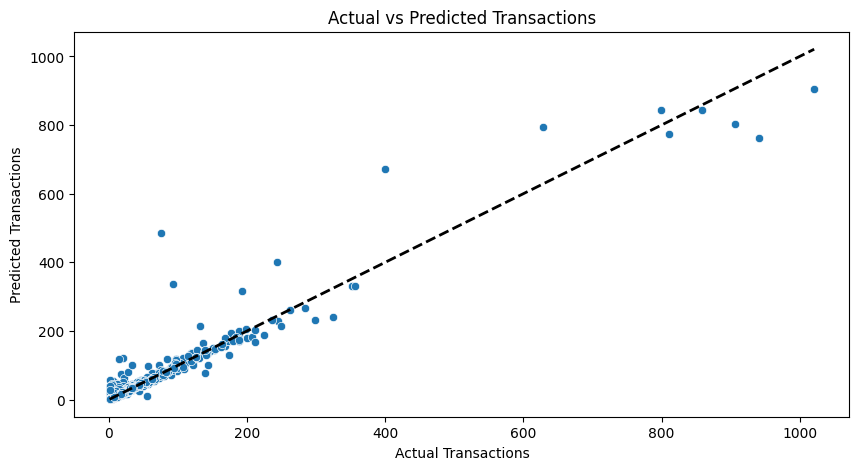

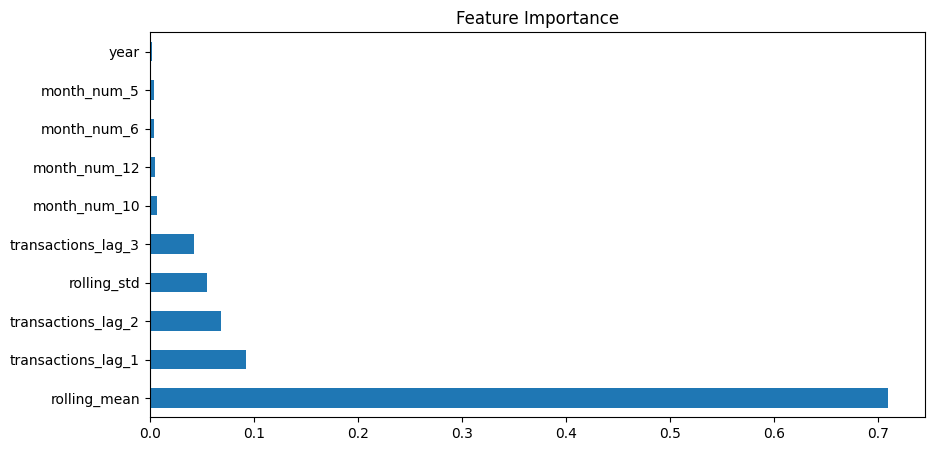

In [31]:
# Actual vs Predicted Transactions
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=results['Random Forest']['preds'])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Transactions')
plt.ylabel('Predicted Transactions')
plt.title('Actual vs Predicted Transactions')
plt.show()

# Feature importance
feature_importance = pd.Series(models_dict['Random Forest'].feature_importances_, index=X_train.columns)
plt.figure(figsize=(10, 5))
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.show()

## Data analysis

### Compute Sales per Product Over the Last 6 Months

In [35]:
# Define function to get top 5 products for any given date
def top_products_last_six_months(reference_date):
    
    # Filter transactions for the last 6 months from reference date
    start_date = reference_date - pd.DateOffset(months=6)
    recent_transactions = all_transactions[
        (all_transactions['date'] >= start_date) & (all_transactions['date'] <= reference_date)
    ]

    # Count sales per product
    product_sales = recent_transactions.groupby('product_id').size().reset_index(name='sales')

    # Get top 5 products
    top_5_products = product_sales.nlargest(5, 'sales')

    return top_5_products

# Example usage: Get top products for July 2019
top_products = top_products_last_six_months(pd.Timestamp("2019-07-31"))
print(top_products)

    product_id  sales
30     Renault  22047
38  Volkswagen   9695
27     Peugeot   9578
2         Audi   9170
3          BMW   8413


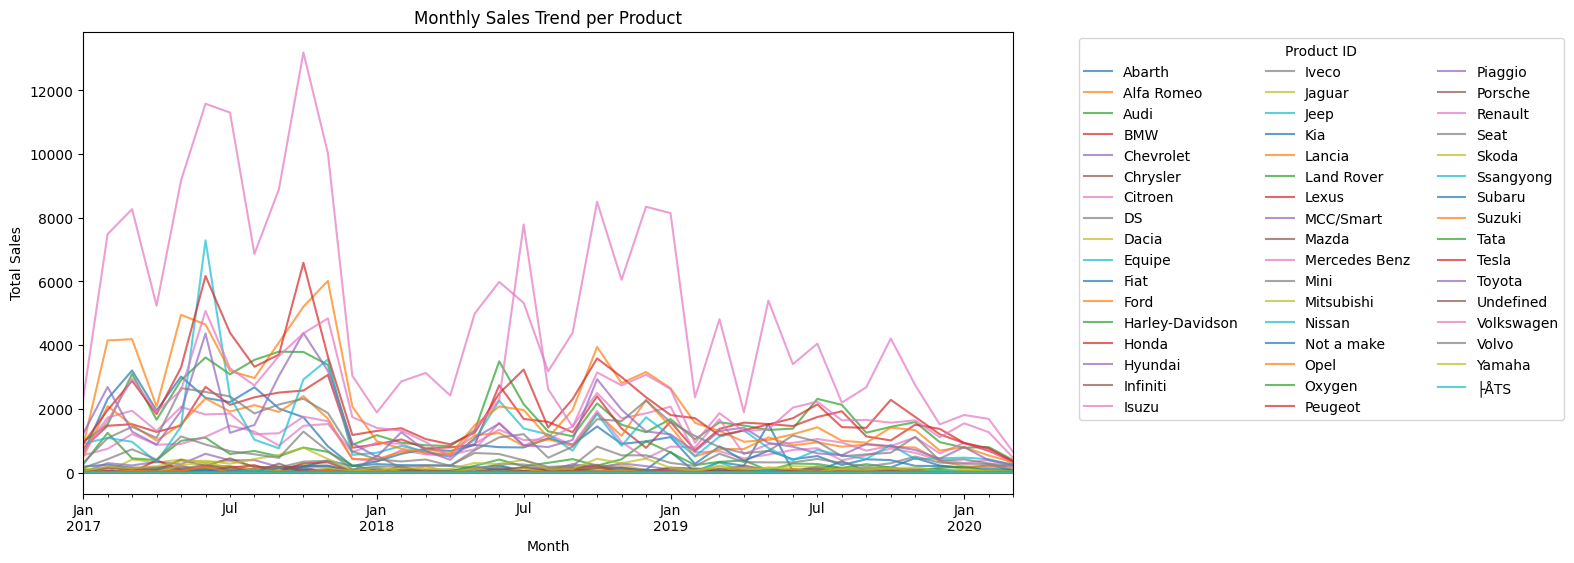

In [32]:
# Aggregate sales per product per month
all_transactions['month'] = all_transactions['date'].dt.to_period('M')
monthly_sales = all_transactions.groupby(['month', 'product_id']).size().unstack(fill_value=0)

# Plot sales trends
plt.figure(figsize=(12, 6))
monthly_sales.plot(ax=plt.gca(), alpha=0.7)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trend per Product")
plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1), title='Product ID', ncol=3)
plt.show()

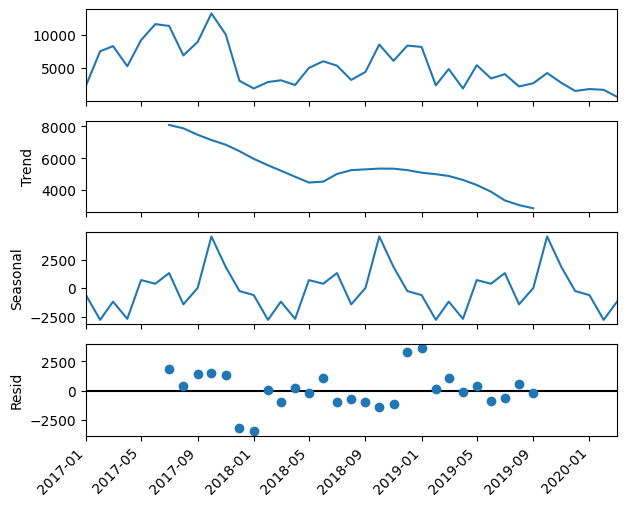

In [50]:
# Select a product to analyze (e.g., top-selling product)
product_id = all_transactions['product_id'].value_counts().idxmax()

# Filter time series data for this product
product_sales = all_transactions[all_transactions['product_id'] == product_id].groupby('month').size()

# Convert Period to Timestamp
product_sales.index = product_sales.index.to_timestamp()

# Apply seasonal decomposition
decomposition = seasonal_decompose(product_sales, model='additive', period=12)

# Plot decomposition
decomposition.plot()
plt.xticks(rotation=45, ha='right')
plt.show()